In [1]:
import dill
import numpy as np
import sys
import os
import pandas as pd
np.set_printoptions(threshold=sys.maxsize)


In [2]:
DPC_df = pd.read_csv("all_data_daily.csv", names=["date-time", "Mean-Energy-Consumed"], header=0)

In [3]:
DPC_df.tail()

,date-time,Mean-Energy-Consumed
824,2014-02-24 23:30:00,0.216976
825,2014-02-25 23:30:00,0.214890
826,2014-02-26 23:30:00,0.212949
827,2014-02-27 23:30:00,0.215866
828,2014-02-28 00:00:00,0.208997


In [4]:
DPC_df = DPC_df.fillna(method='ffill')

In [5]:
DPC_df.plot()

In [6]:
data = np.array(DPC_df["Mean-Energy-Consumed"])

In [7]:
train_test_ratio = 0.8
data_train = data[0:int(data.shape[0]*train_test_ratio)]

In [8]:
data_test = data[int(data.shape[0]*train_test_ratio):]
data_test.shape[0]

166

In [9]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#np.seterr(divide='ignore', invalid='ignore')
scaler2 = StandardScaler()
scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(np.reshape(data_train,(data_train.shape[0],1)))
normalized_data = scaler2.fit_transform(normalized_data)

inverseTcheck = scaler2.inverse_transform(normalized_data)
inverseTcheck = scaler.inverse_transform(inverseTcheck)

In [10]:
normalized_data_test = scaler.transform(np.reshape(data_test,(data_test.shape[0],1)))
normalized_data_test = scaler2.transform(normalized_data_test)

In [11]:
normalized_data_test.shape

(166, 1)

In [12]:
normalized_data.shape

(663, 1)

In [13]:
max(normalized_data)

array([2.8163578])

In [41]:
len(normalized_data)

663

In [14]:
lag = 30
#shift time series data 30 days a ahead
interval_train = 30
x_train = [normalized_data[i:i+interval_train] for i in range(0,len(normalized_data) - lag)]
target = normalized_data[lag:]

In [15]:
normalized_data_test
x_test = [normalized_data_test[i:i+interval_train] for i in range(0,len(normalized_data_test) - lag)]
target_test = normalized_data_test[lag:]

In [16]:
print(target.shape)
print(target_test.shape)
print(len(x_train))
len(x_test)

(633, 1)
(136, 1)
633


136

In [17]:
np_x_train = np.array(x_train)
np_x_test = np.array(x_test)

In [18]:
np_x_train.shape
np_x_test.shape

(136, 30, 1)

In [19]:
x_train2=np_x_train
y_train2=target

In [20]:
print(x_train2.shape)
print(y_train2.shape)
print(x_train2.shape[2])

(633, 30, 1)
(633, 1)
1


In [21]:
x_train2.shape[1:]

(30, 1)

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
import cartopy.crs as ccrs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow.keras as keras
import types
import tempfile
import os

In [162]:
from keras.initializers import glorot_uniform  # Or your initializer of choice
import keras.backend as K

initial_weights = model.get_weights()

backend_name = K.backend()
if backend_name == 'tensorflow': 
    k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
elif backend_name == 'theano': 
    k_eval = lambda placeholder: placeholder.eval()
else: 
    raise ValueError("Unsupported backend")

new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

model.set_weights(new_weights)

In [163]:
model = Sequential()
model.add(LSTM(128, input_shape= x_train2.shape[1:], activation='tanh', return_sequences=True))
#model.add(LSTM(100, input_shape= (x_train2.shape[1:]), activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(y_train2.shape[1], activation='tanh'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [164]:
opt = tf.keras.optimizers.Adamax(learning_rate=1, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#opt = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

model.compile(
    loss='mean_absolute_error',
    optimizer='adam',
    metrics=['mae'],
)

model.fit(x_train2,
          y_train2,
          epochs=3)

Train on 633 samples
Epoch 1/3
633/633 [==============================] - 2s 4ms/sample - loss: 0.3991 - mean_absolute_error: 0.3991
Epoch 2/3
633/633 [==============================] - 1s 2ms/sample - loss: 0.2863 - mean_absolute_error: 0.2863
Epoch 3/3
633/633 [==============================] - 1s 2ms/sample - loss: 0.2755 - mean_absolute_error: 0.2755


In [165]:
pred = model.predict(x_train2)
data_out = scaler.inverse_transform(scaler2.inverse_transform(pred))

In [166]:
data_out.shape

(633, 1)

In [167]:
data_out_df = pd.DataFrame(np.hstack([pred,y_train2,x_train2[:,29]]))

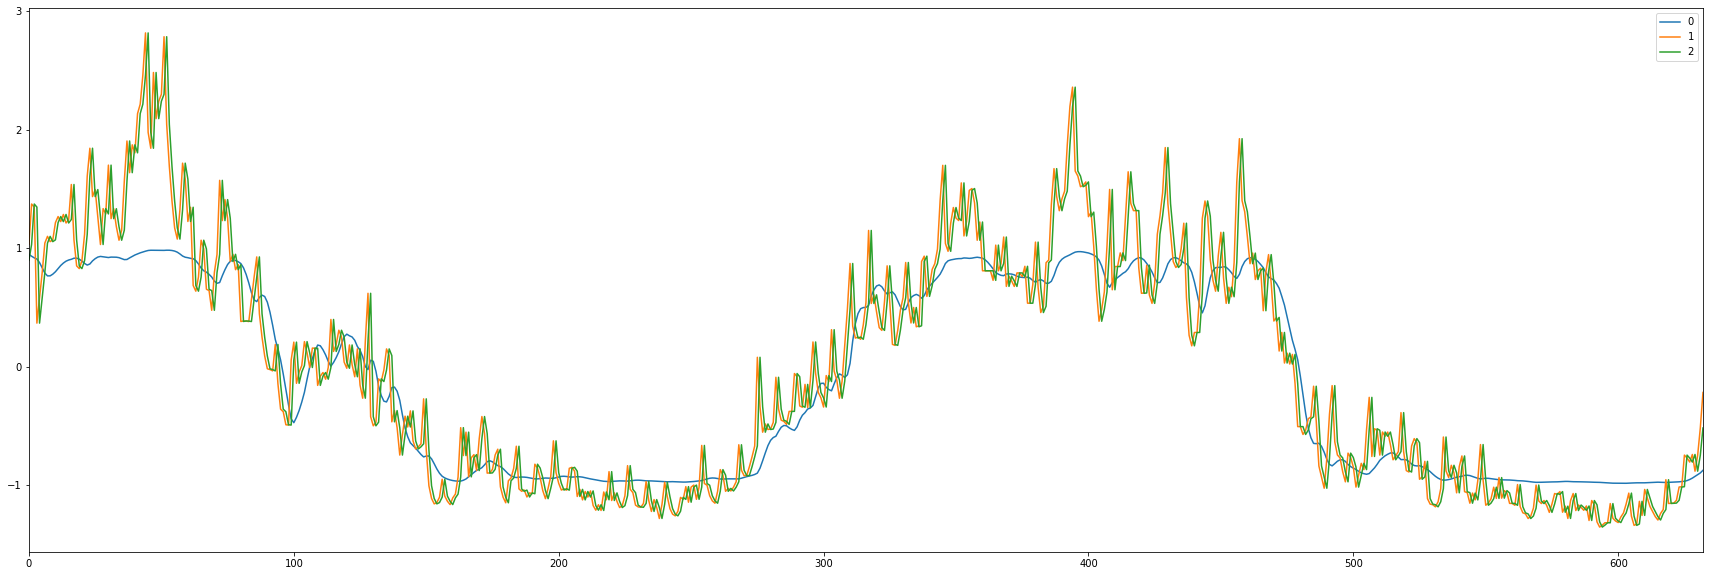

In [168]:
data_out_df.plot(figsize=(30,10))

In [169]:
pred_test = model.predict(np_x_test)
data_out_pred_test = scaler.inverse_transform(scaler2.inverse_transform(pred_test))

In [170]:
max(data_out_pred_test)

array([0.24843606], dtype=float32)

In [171]:
data_out_pred_test.shape

(136, 1)

In [172]:
np_x_test[:,29].shape

(136, 1)

In [173]:
org_x_test = scaler.inverse_transform(scaler2.inverse_transform(np_x_test[:,29]))

In [174]:
pred_test_shift1day_ahead =  np.insert(data_out_pred_test, 0, [None], axis=0)
print(pred_test_shift1day_ahead.shape)
pred_test_shift1day_ahead

(137, 1)


array([[       nan],
       [0.20011099],
       [0.20377381],
       [0.20491117],
       [0.2037581 ],
       [0.2019649 ],
       [0.20151208],
       [0.20020849],
       [0.19801413],
       [0.19519293],
       [0.19241172],
       [0.18995762],
       [0.18876648],
       [0.18940401],
       [0.19095126],
       [0.19309014],
       [0.19563176],
       [0.19835547],
       [0.20050365],
       [0.20238411],
       [0.20701152],
       [0.21125545],
       [0.21583211],
       [0.21942379],
       [0.2208349 ],
       [0.22182088],
       [0.22470106],
       [0.22916673],
       [0.23256527],
       [0.23344176],
       [0.23324811],
       [0.23231442],
       [0.23132166],
       [0.23172776],
       [0.23437667],
       [0.23616254],
       [0.23729597],
       [0.23932207],
       [0.24119997],
       [0.2425302 ],
       [0.24382222],
       [0.2457339 ],
       [0.24663864],
       [0.24676853],
       [0.2461993 ],
       [0.24483879],
       [0.24284165],
       [0.241

In [175]:
data_out_test_df = pd.DataFrame(np.hstack([pred_test_shift1day_ahead,np.vstack((org_x_test,[None]))]))

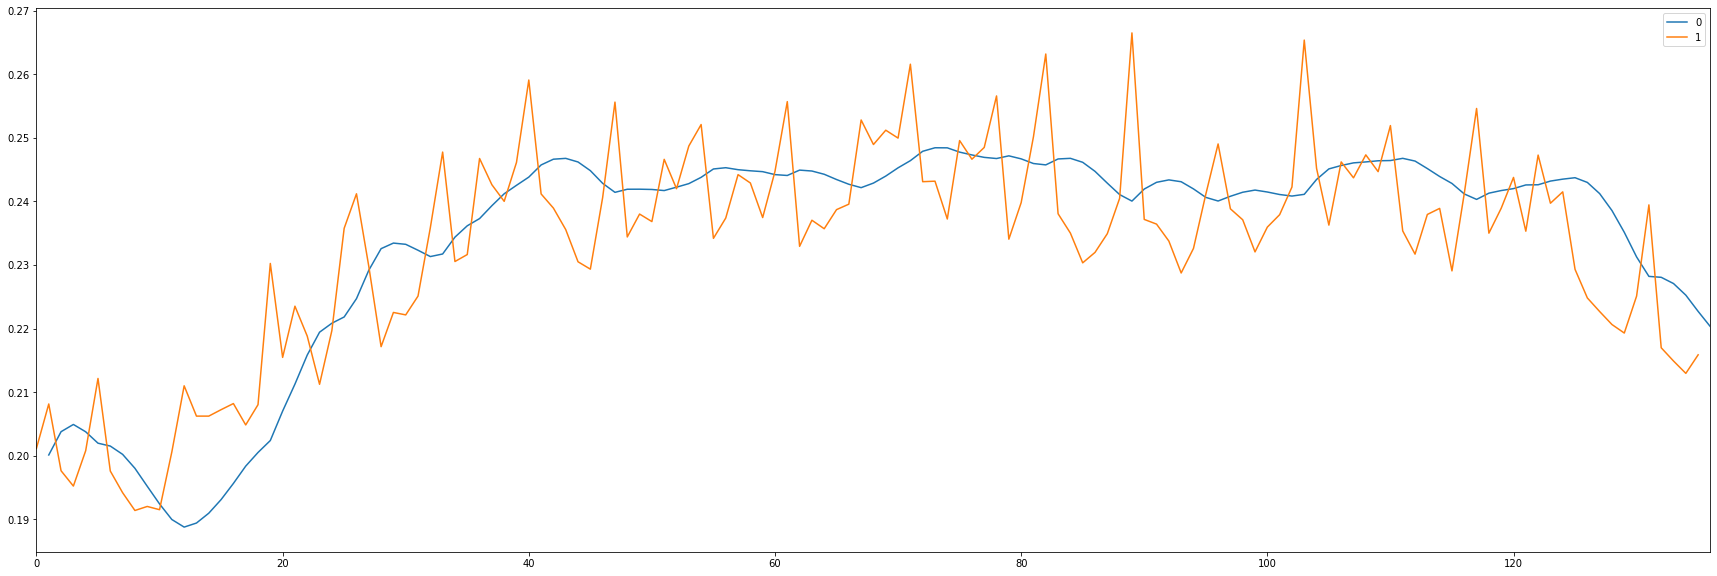

In [176]:
data_out_test_df.plot(figsize=(30,10))

In [177]:
from sklearn.metrics import mean_absolute_error

Test_MAE = mean_absolute_error(np.vstack((org_x_test,[None]))[1:-1], pred_test_shift1day_ahead[1:-1])

In [178]:
Test_MAE 

0.008266292909377717

In [179]:
Test_residuals = np.vstack((org_x_test,[None]))[1:-1] - pred_test_shift1day_ahead[1:-1]

In [180]:
residual_plot = pd.DataFrame(np.hstack([Test_residuals, pred_test_shift1day_ahead[1:-1]]), columns=['residuals','pred'])